In [1]:
import numpy as np
from u8timeseries import TimeSeries
import pandas as pd
import statsmodels.tsa.holtwinters as hw
from u8timeseries.models.autoregressive_model import AutoRegressiveModel
from u8timeseries.models.exponential_smoothing import ExponentialSmoothing
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
import math

In [2]:
class Theta(AutoRegressiveModel):
    
    def __init__(self):
        super().__init__()
        self.model = None
        self.coef = 1
        self.alpha = 1
        self.length = 0
        self.is_seasonal = False
        self.seasonality = None
        self.period_length = 12
        
    def fit(self, ts, period_length=12):
        super().fit(ts)
        self.length = len(ts)
        self.period_length = period_length
        self.is_seasonal = self._check_seasonality(ts, self.period_length)
        if self.is_seasonal:
            ts, self.seasonality = self._seasonal_adjustment(ts, self.period_length)
            
        self.model = hw.SimpleExpSmoothing(ts.values()).fit()
        # TODO: Figure out why the coef is divided by 2?
        self.coef = np.polyfit(np.array([i for i in range(0, self.length)]), ts.values(), 1)[0] / 2.
        self.alpha = self.model.params["smoothing_level"]

    def predict(self, n):
        super().predict(n)
        forecast = self.model.forecast(n)
        drift = self.coef * np.array([i + (1 - (1 - self.alpha) ** self.length) / self.alpha for i in range(0, n)])
        forecast += drift
        
        if self.is_seasonal:
            replicated_seasonality = np.tile(self.seasonality[-self.period_length:], math.ceil(n / self.period_length))[:n]
            forecast *= replicated_seasonality
        return self._build_forecast_series(forecast)
    
    def _check_seasonality(self, ts, m):
        n_unique = np.unique(ts.values()).shape[0]
        if m > 1 and n_unique > 1 and self.length > m:
            r = acf(ts.values(), nlags=m).tolist()[1:]
            stat = math.sqrt((1 + 2 * sum(map(lambda x: x**2, r[:m-1]))) / self.length)
            return (abs(r[m-1]) / stat) > norm.ppf(0.95)
        return False
    
    def _seasonal_adjustment(self, ts, frequency, model='multiplicative'):
        decomp = seasonal_decompose(ts.values(), model=model, freq=frequency)
        seasonality = decomp.seasonal
        if (seasonality < 1e-6).any():
            print("WARNING seasonal indexes equal to zero, using non-seasonal Theta method ")
        else:
            if model == 'multiplicative':
                ts = TimeSeries.from_times_and_values(ts.time_index(), ts.values() / seasonality)
            else:
                ts = TimeSeries.from_times_and_values(ts.time_index(), ts.values() - seasonality)
        return ts, seasonality

In [3]:
df = pd.read_csv('../examples/AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
train, val = series.split_after(pd.Timestamp('19570101'))

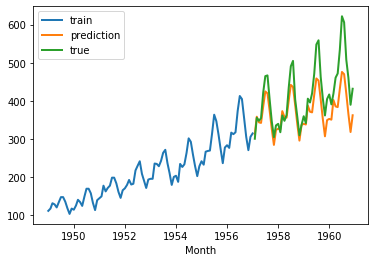

In [4]:
model = Theta()
model.fit(train)
pred = model.predict(len(val))
train.plot(lw=2, label='train')
pred.plot(lw=2, label='prediction')
val.plot(lw=2, label='true')
plt.legend()

In [5]:
class Theta2(AutoRegressiveModel):
    
    def __init__(self):
        super().__init__()
        self.model = None
        self.coef = 1
        self.alpha = 1
        self.length = 0
        self.is_seasonal = False
        self.seasonality = None
        self.period_length = 12
        
    def fit(self, ts, period_length=None):
        super().fit(ts)
        self.length = len(ts)
        self.is_seasonal = self._check_seasonality(ts, period_length)
        if self.is_seasonal:
            ts, self.seasonality = self._seasonal_adjustment(ts, self.frequency)
            
        self.model = hw.SimpleExpSmoothing(ts.values()).fit()
        # TODO: Figure out why the coef is divided by 2?
        self.coef = np.polyfit(np.array([i for i in range(0, self.length)]), ts.values(), 1)[0] / 2.0
        self.alpha = self.model.params["smoothing_level"]

    def predict(self, n):
        super().predict(n)
        forecast = self.model.forecast(n)
        drift = self.coef * np.array([i + (1 - (1 - self.alpha) ** self.length) / self.alpha for i in range(0, n)])
        forecast += drift
        
        if self.is_seasonal:
            replicated_seasonality = np.tile(self.seasonality[-self.frequency:], math.ceil(n / self.frequency))[:n]
            forecast *= replicated_seasonality
        return self._build_forecast_series(forecast)

    
    def _check_seasonality(self, ts, m=None, max_lag=24):
        n_unique = np.unique(ts.values()).shape[0]
        if n_unique > 1:
            r = acf(ts.values(), nlags=max_lag)
            if m is None:
                grad = np.gradient(r)
                signs_changes = np.diff(np.sign(grad))
                m = np.nonzero((signs_changes == -2))[0][0]
            stat = self.compute_stats(r, m)
            self.frequency = m
            r = r[1:]
            return (abs(r[m-1]) / stat) > norm.ppf(0.95)
        return False, 0
    
    def compute_stats(self, r, m):
        return math.sqrt((1 + 2 * sum(map(lambda x: x**2, r[:m-1]))) / self.length)
    
    def _seasonal_adjustment(self, ts, frequency, model='multiplicative'):
        decomp = seasonal_decompose(ts.values(), model=model, freq=frequency)
        seasonality = decomp.seasonal
        if (seasonality < 1e-6).any():
            print("WARNING seasonal indexes equal to zero, using non-seasonal Theta method ")
        else:
            if model == 'multiplicative':
                ts = TimeSeries.from_times_and_values(ts.time_index(), ts.values() / seasonality)
            else:
                ts = TimeSeries.from_times_and_values(ts.time_index(), ts.values() - seasonality)
        return ts, seasonality

In [6]:
df = pd.read_csv('../examples/AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
train, val = series.split_after(pd.Timestamp('19570101'))

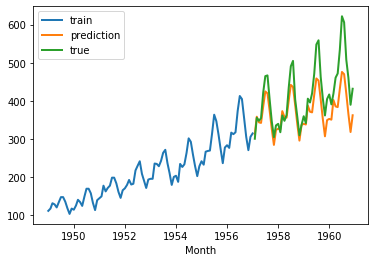

In [7]:
model = Theta2()
model.fit(train, 12)
pred = model.predict(len(val))
train.plot(lw=2, label='train')
pred.plot(lw=2, label='prediction')
val.plot(lw=2, label='true')
plt.legend()

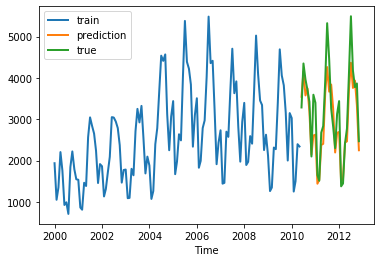

In [8]:
df = pd.read_csv('./nz_destm_2000-2012.csv', delimiter=",")
available = ['Australia', 'Cook Islands', 'Fiji', 'Samoa', 'India', 'Thailand', 'United Kingdom', 'United States of America','TOTAL ALL COUNTRIES OF MAIN DESTINATION']
series = TimeSeries.from_dataframe(df, 'Time', available[2])
train, val = series.split_after(pd.Timestamp('20100501'))
model = Theta2()
model.fit(train, 12)
pred = model.predict(len(val))
train.plot(lw=2, label='train')
pred.plot(lw=2, label='prediction')
val.plot(lw=2, label='true')
plt.legend()

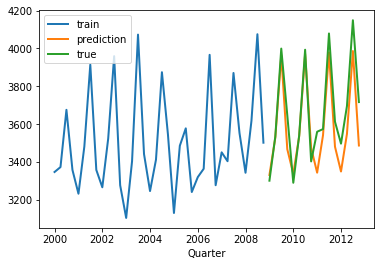

In [9]:
df = pd.read_csv('./_births_and_deaths.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Quarter', 'Male Deaths')
train, val = series.split_after(pd.Timestamp('2008Q4'))
model = Theta2()
model.fit(train, 4)
pred = model.predict(len(val))
train.plot(lw=2, label='train')
pred.plot(lw=2, label='prediction')
val.plot(lw=2, label='true')
plt.legend()